In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("ggplot")
plt.rcParams["font.family"] = "sans-serif"
sns.set_palette("dark")
sns.set_context("talk")

import numpy as np

from IPython.display import HTML, display, SVG

import pydot
from pydrake.all import (AddMultibodyPlantSceneGraph, DiagramBuilder, BasicVector,
                        Parser, Saturation, Simulator, PlanarSceneGraphVisualizer, 
                        LinearQuadraticRegulator, AbstractValue, MeshcatVisualizer, 
                        StartMeshcat, WrapToSystem, SceneGraph, DiscreteTimeLinearQuadraticRegulator,
                        JacobianWrtVariable, eq, SnoptSolver)    

from pydrake.systems.primitives import LogVectorOutput, ConstantVectorSource
from pydrake.multibody.inverse_kinematics import PositionConstraint, AddUnitQuaternionConstraintOnPlant


from pydrake.multibody.plant import ContactResults
from pydrake.autodiffutils import AutoDiffXd, InitializeAutoDiff, ExtractGradient, ExtractValue
from underactuated.meshcat_cpp_utils import MeshcatSliders, MeshcatJointSliders
from Custom_LeafSystems import *

from pydrake.math import RollPitchYaw_, RotationMatrix_, RigidTransform_

from tqdm import tqdm as tqdm

from Linearize import getGradients

from pydrake.solvers.mathematicalprogram import MathematicalProgram, Solve
import os
from datetime import datetime


In [2]:
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7000


In [3]:
def set_home(plant, context, ad=1.):

    hip_roll = 0.1
    hip_pitch = 1
    knee = 1.55

    back_hip_pitch = 0.9
    back_knee = 1.

    if np.array([ad]).dtype == float:
        RPY = RollPitchYaw_[float](np.array([0., -np.pi/2+0.1, 0.]))
        transform = RigidTransform_[float]([0, 0, 0.2645])
        transform.set_rotation(RPY)
    else:
        RPY = RollPitchYaw_[AutoDiffXd](np.array([0., -np.pi/2+0.1, 0.]))
        transform = RigidTransform_[AutoDiffXd]([0, 0, 0.2645])
        transform.set_rotation(RPY)
        
        # hip_roll = InitializeAutoDiff(hip_roll)
        # hip_pitch = InitializeAutoDiff(hip_pitch)
        # knee = InitializeAutoDiff(knee)
        # back_hip_pitch = InitializeAutoDiff(back_hip_pitch)
        # back_knee = InitializeAutoDiff(back_knee)

    plant.GetJointByName("front_right_hip_roll").set_angle(context, -hip_roll)
    plant.GetJointByName("front_right_hip_pitch").set_angle(context, hip_pitch)
    plant.GetJointByName("front_right_knee").set_angle(context, -knee)
    plant.GetJointByName("front_left_hip_roll").set_angle(context, hip_roll)
    plant.GetJointByName("front_left_hip_pitch").set_angle(context, hip_pitch)
    plant.GetJointByName("front_left_knee").set_angle(context, -knee)
    plant.GetJointByName("back_right_hip_roll").set_angle(context, -hip_roll)
    plant.GetJointByName("back_right_hip_pitch").set_angle(context, back_hip_pitch)
    plant.GetJointByName("back_right_knee").set_angle(context, back_knee)
    plant.GetJointByName("back_left_hip_roll").set_angle(context, hip_roll)
    plant.GetJointByName("back_left_hip_pitch").set_angle(context, back_hip_pitch)
    plant.GetJointByName("back_left_knee").set_angle(context, back_knee)

    plant.SetFreeBodyPose(context, plant.GetBodyByName("body"), transform)


time_step = 1/1000.
builder = DiagramBuilder()
plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=time_step)
body = Parser(plant).AddModelFromFile("littledog/LittleDog.urdf")
ground = Parser(plant).AddModelFromFile("littledog/ground.urdf")
plant.Finalize()

meshcat.Delete()
vis = MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)
context = plant.CreateDefaultContext()

num_pos = plant.num_positions()
num_vel = plant.num_velocities()
num_act = plant.num_actuators()
num_disc_states = context.num_total_states() - context.num_continuous_states()
num_contact = 2
fb_num_pos = 7
fb_num_vel = 6

set_home(plant, context)

CoM_0 = plant.CalcCenterOfMassPositionInWorld(context)

plant.get_actuation_input_port().FixValue(context, np.zeros(num_act))

# display(SVG(pydot.graph_from_dot_data(plant.GetTopologyGraphvizString())[0].create_svg()))

# diagram = builder.Build()
# display(SVG(pydot.graph_from_dot_data(diagram.GetGraphvizString(max_depth=2))[0].create_svg()))

x0 = plant.GetPositions(context)

foot_L = "back_left_foot_center"
foot_R = "back_right_foot_center"

# def PoseOptimization():
#     context_diagram = diagram.CreateDefaultContext()
#     plant_context_from_diagram = diagram.GetSubsystemContext(plant, context_diagram)
#     set_home(plant, plant_context_from_diagram)

#     sliders = MeshcatJointSliders(meshcat, plant, context_diagram)
#     sliders.Run(vis, context_diagram)
#     meshcat.DeleteAddedControls()
#     meshcat.Delete()

# PoseOptimization()

Solution found? False.
['unit quaternion constraint[0]: 0.999900 <= 1.003663 <= 1.000100', 'Dynamics constraint[0]: -0.000010 <= -0.256868 <= 0.000010', 'Dynamics constraint[1]: -0.000010 <= -0.135643 <= 0.000010', 'Dynamics constraint[2]: -0.000010 <= 0.001247 <= 0.000010', 'Dynamics constraint[5]: -0.000010 <= 6.439132 <= 0.000010', 'Torque constraint[0]: -0.000100 <= 0.003126 <= 0.000100', 'Torque constraint[1]: -0.000100 <= -0.021719 <= 0.000100', 'Torque constraint[2]: -0.000100 <= -0.005395 <= 0.000100', 'Torque constraint[3]: -0.000100 <= -0.003110 <= 0.000100', 'Torque constraint[4]: -0.000100 <= -0.021529 <= 0.000100', 'Torque constraint[5]: -0.000100 <= -0.005398 <= 0.000100', 'Torque constraint[6]: -0.000100 <= -0.029941 <= 0.000100', 'Torque constraint[7]: -0.000100 <= 0.420117 <= 0.000100', 'Torque constraint[8]: -0.000100 <= -0.050337 <= 0.000100', 'Torque constraint[9]: -0.000100 <= 0.035434 <= 0.000100', 'Torque constraint[10]: -0.000100 <= 0.107333 <= 0.000100', 'Torqu

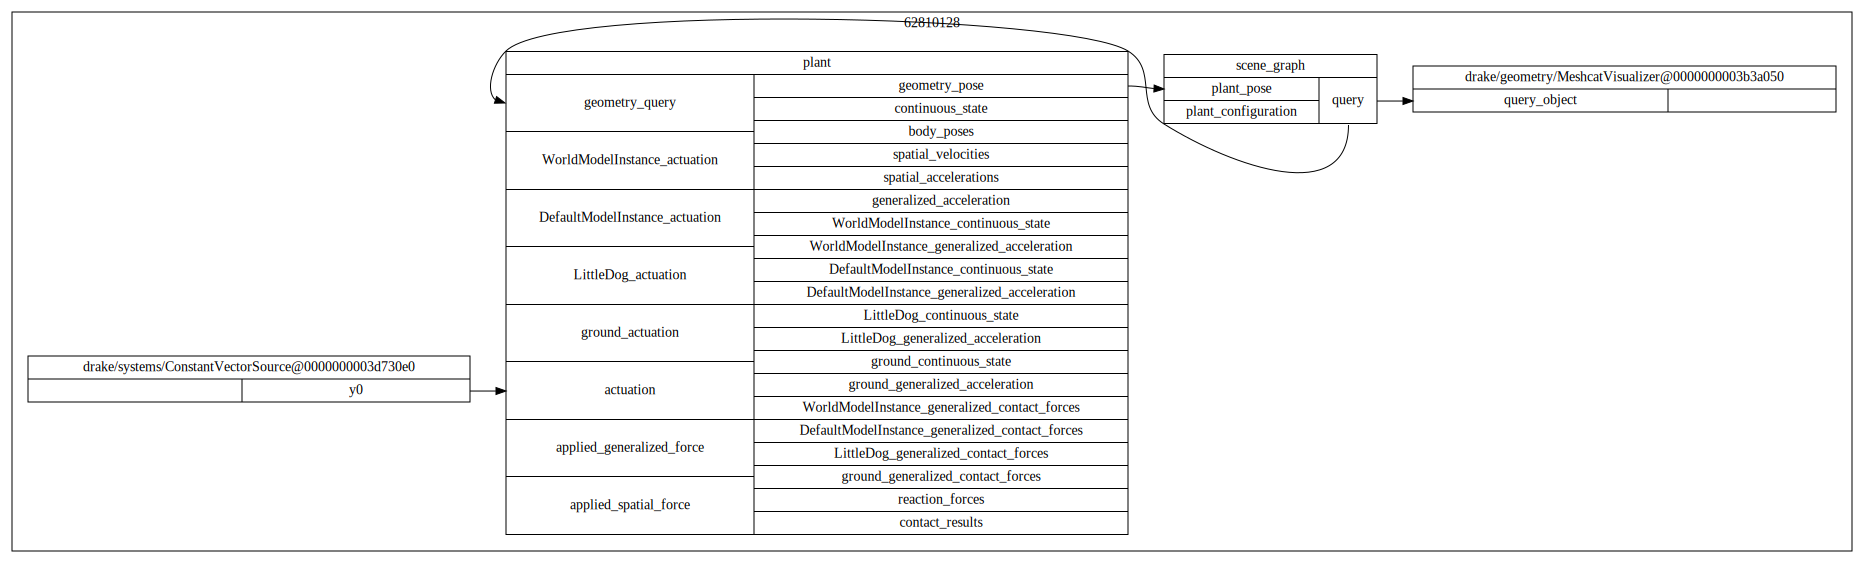

In [4]:
# Pose optimization

plant_f = plant
context_f = plant_f.CreateDefaultContext()

plant_ad = plant.ToAutoDiffXd()
context_ad = plant_ad.CreateDefaultContext()

set_home(plant_f, context_f)
set_home(plant_ad, context_ad, ad=None)

B = plant.MakeActuationMatrix()

def makePosConstraint(plant, context):
    # Position constraint feet
    epsilon = 1E-1

    p_AQ_lower = np.array([-0.09-epsilon, -epsilon, 0])
    p_AQ_upper = np.array([0.09+epsilon, epsilon, 0])
    p_BQ = np.zeros(3)

    frame_left = plant.GetFrameByName(foot_L)
    frame_right = plant.GetFrameByName(foot_R)
    frame_world = plant.world_frame()

    pos_constraint_left = PositionConstraint(plant=plant,
                            frameA=frame_world,
                            p_AQ_lower=p_AQ_lower,
                            p_AQ_upper=p_AQ_upper,
                            frameB=frame_left,
                            p_BQ=p_BQ,
                            plant_context=context
                            )

    # Position constraint foot right
    pos_constraint_right = PositionConstraint(plant=plant,
                            frameA=frame_world,
                            p_AQ_lower=p_AQ_lower,
                            p_AQ_upper=p_AQ_upper,
                            frameB=frame_right,
                            p_BQ=p_BQ,
                            plant_context=context
                            )

    return pos_constraint_left, pos_constraint_right

pos_constraint_left, pos_constraint_right = makePosConstraint(plant_ad, context_ad)

def get_foot_Jacobian(var):

    if var.dtype == float:
        plant = plant_f
        context = context_f
        p_BoBi_B_left = np.zeros(3)
        p_BoBi_B_right = np.zeros(3)
    else:
        plant = plant_ad
        context = context_ad 
        p_BoBi_B_left = InitializeAutoDiff(np.zeros(3))
        p_BoBi_B_right = InitializeAutoDiff(np.zeros(3))

    frame_left = plant.GetFrameByName(foot_L)
    frame_right = plant.GetFrameByName(foot_R)
    frame_world = plant.world_frame()

    Jc_left = plant.CalcJacobianTranslationalVelocity(
            context,
            JacobianWrtVariable(1),
            frame_left,
            p_BoBi_B_left,
            frame_world,
            frame_world
            )

    Jc_right = plant.CalcJacobianTranslationalVelocity(
                context,
                JacobianWrtVariable(1),
                frame_right,
                p_BoBi_B_right,
                frame_world,
                frame_world
                )

    return np.vstack((Jc_left, Jc_right))


def calcUnactuatedDynamics(vars):

    split_at = [num_act, num_act + num_pos]
    tau, pos, lambda_c = np.split(vars, split_at)
    
    if tau.dtype == float:
        plant = plant_f
        context = context_f
    else:
        plant = plant_ad
        context = context_ad 

    plant.SetPositions(context, pos)
    plant.SetVelocities(context, np.zeros(num_vel))
    plant.get_actuation_input_port().FixValue(context, tau)

    # M, Cv, taug
    taug = plant.CalcGravityGeneralizedForces(context)
    Cv = plant.CalcBiasTerm(context)
    Jc = get_foot_Jacobian(tau)
    
    return taug[:6] + Jc.T[:6, :] @ lambda_c - Cv[:6]


def torque_constraint(vars):
    split_at = [num_act, num_act + num_pos]
    tau, pos, lambda_c = np.split(vars, split_at)
    
    if tau.dtype == float:
        plant = plant_f
        context = context_f
    else:
        plant = plant_ad
        context = context_ad 

    plant.SetPositions(context, pos)
    plant.SetVelocities(context, np.zeros(num_vel))
    plant.get_actuation_input_port().FixValue(context, tau)

    # M, Cv, taug
    taug = plant.CalcGravityGeneralizedForces(context)
    Cv = plant.CalcBiasTerm(context)
    Jc = get_foot_Jacobian(tau)

    B_act = B[6:, :]
    
    return tau + np.linalg.inv(B_act) @ (Cv[6:] - taug[6:] - Jc.T[6:, :] @ lambda_c ) 


def CostTorque(tau):
    return tau.dot(tau)


def CostCoM(q):

    if q.dtype == float:
        plant = plant_f
        context = context_f
    else:
        plant = plant_ad
        context = context_ad

    plant.SetPositions(context, q)
    CoM = plant.CalcCenterOfMassPositionInWorld(context)

    CoM_xy = CoM[0:2]
    CoM_z = CoM[2]

    return CoM_xy.dot(CoM_xy) + 1 / (w_CoM*CoM_z)


def getCoM(q):

    if q.dtype == float:
        plant = plant_f
        context = context_f
    else:
        plant = plant_ad
        context = context_ad

    plant.SetPositions(context, q)
    CoM = plant.CalcCenterOfMassPositionInWorld(context)[0]

    return CoM


# Write Mathematical program
prog = MathematicalProgram()

# Define decision variables
pos = prog.NewContinuousVariables(num_pos, "positions")
torques = prog.NewContinuousVariables(num_act, "torques")
lambdas = prog.NewContinuousVariables(num_contact*3, "lambda")

# Unit quaternion constraint
# unit_quat = AddUnitQuaternionConstraintOnPlant(plant_ad, pos, prog)

# Bent knee and hip
# knee_constraint = prog.AddConstraint(pos[4 + fb_num_pos] <= -0.3).evaluator().set_description("Knee bend constraint")
# hip_constraint = prog.AddConstraint(pos[3 + fb_num_pos] >= 0.15).evaluator().set_description("Hip bend constraint")
# knee_constraint_L = prog.AddConstraint(pos[9 + fb_num_pos] <= -0.3).evaluator().set_description("Knee bend constraint")
# hip_constraint_L = prog.AddConstraint(pos[8 + fb_num_pos] >= 0.15).evaluator().set_description("Hip bend constraint")

# Symmetric pose Constraints
# prog.AddConstraint(pos[2 + fb_num_pos] == pos[7 + fb_num_pos]).evaluator().set_description("Symmetry in hip roll")
# prog.AddConstraint(pos[3 + fb_num_pos] == pos[8 + fb_num_pos]).evaluator().set_description("Symmetry in hip pitch")
# prog.AddConstraint(pos[4 + fb_num_pos] == pos[9 + fb_num_pos]).evaluator().set_description("Symmetry in knee pitch")
# prog.AddConstraint(pos[5 + fb_num_pos] == pos[10 + fb_num_pos]).evaluator().set_description("Symmetry in foot pitch")
# prog.AddConstraint(pos[6 + fb_num_pos] == pos[11 + fb_num_pos]).evaluator().set_description("Symmetry in foot roll")

unit_quat_eps = 1e-4

# Quaternion unit length constraint
(prog.AddConstraint(lambda x: [x @ x], [1 - unit_quat_eps], [1 + unit_quat_eps], pos[0:4]).evaluator().set_description("unit quaternion constraint"))

# Limit Inividual parts of quaternion to be between -1 and 1
(prog.AddBoundingBoxConstraint(-1.0, 1.0, pos[0]).evaluator().set_description("quat0 limit constraint"))
(prog.AddBoundingBoxConstraint(-1.0, 1.0, pos[1]).evaluator().set_description("quat1 limit constraint"))
(prog.AddBoundingBoxConstraint(-1.0, 1.0, pos[2]).evaluator().set_description("quat2 limit constraint"))
(prog.AddBoundingBoxConstraint(-1.0, 1.0, pos[3]).evaluator().set_description("quat3 limit constraint"))

# Friction cone constraint
friction_left = prog.AddConstraint(lambdas[0]**2 + lambdas[1]**2 <= lambdas[2]**2).evaluator().set_description("left foot friction cone")
friction_right = prog.AddConstraint(lambdas[3]**2 + lambdas[4]**2 <= lambdas[5]**2).evaluator().set_description("right foot friction cone")

# Dynamics constraints for unactuated DOFs
vars = np.concatenate((torques, pos, lambdas))
dyn_constraint = prog.AddConstraint(calcUnactuatedDynamics, lb=[-1e-5]*(6), ub=[1e-5]*(6), vars=vars)
dyn_constraint.evaluator().set_description("Dynamics constraint")

# Torque constraint for actuated DOFs
dyn_constraint = prog.AddConstraint(torque_constraint, lb=[-1E-4]*(num_act), ub=[1E-4]*(num_act), vars=vars) 
dyn_constraint.evaluator().set_description("Torque constraint")

# Postiive contact force
prog.AddConstraint(lambdas[2] >= 1E-5), prog.AddConstraint(lambdas[5] >= 1E-5)

# Foot position constraints
foot_left_pos = prog.AddConstraint(pos_constraint_left, pos).evaluator().set_description("left foot position")
foot_right_pos = prog.AddConstraint(pos_constraint_right, pos).evaluator().set_description("foot right position")

w_CoM = 0.1
prog.AddCost(CostTorque, vars=torques)
prog.AddCost(CostCoM, vars=pos)

fc_guess = -plant.gravity_field().gravity_vector() * plant.CalcTotalMass(context) / 2
fc_guess = np.hstack((fc_guess, fc_guess))

tau_guess = np.zeros(num_act)

# Setting initial guess for decision variables
prog.SetInitialGuess(pos, x0[:num_pos])
prog.SetInitialGuess(torques, tau_guess)
prog.SetInitialGuess(lambdas, fc_guess)

# Write solver status to file
path = f"Logs/littledog/{datetime.now().strftime('%Y-%m-%d_%H-%M_SNOPT.out')}"
snopt = SnoptSolver().solver_id()
prog.SetSolverOption(snopt, 'Print file', path)

# Solve optimization problem
result = Solve(prog)

q = result.GetSolution(pos)
tau = result.GetSolution(torques)
fc = result.GetSolution(lambdas)

x0 = np.hstack((q, np.zeros(num_vel)))

# In case of infeasible quaternion constraint
x0[0:4] = x0[0:4] / (x0[0:4].dot(x0[0:4]))

print(f'Solution found? {result.is_success()}.')

if not result.is_success():
    infeasible = result.GetInfeasibleConstraintNames(prog)
    print(infeasible)

plant.SetPositions(context, q)

CoM = plant.CalcCenterOfMassPositionInWorld(context)

with open(path, "a") as file:
    file.write("\n")
    np.savetxt(file, q, delimiter=",", header="Array of robot joint angles")
    file.write("\n")
    np.savetxt(file, tau, delimiter=",", header="Array of torques")
    file.write("\n")
    np.savetxt(file, fc, delimiter=",", header="Array of contact forces")
    file.write("\n")
    np.savetxt(file, CoM, delimiter=",", header="CoM location")


In [ ]:

# Wire contact detection logic
generic_input = builder.AddSystem(ConstantVectorSource(np.zeros(num_act)))
# contact = builder.AddSystem(ReadContactResults(plant, foot_L))

# builder.Connect(plant.get_contact_results_output_port(), contact.get_input_port())
builder.Connect(generic_input.get_output_port(), plant.get_actuation_input_port())

# logger_is_contact = LogVectorOutput(contact.get_output_port(1), builder, publish_period=1/1000)

diagram = builder.Build()

# display(SVG(pydot.graph_from_dot_data(diagram.GetGraphvizString(max_depth=2))[0].create_svg()))

simulator = Simulator(diagram)
sim_context = simulator.get_mutable_context()

sim_context.SetTime(0.)
sim_context.SetDiscreteState(x0)
vis.StartRecording()
simulator.AdvanceTo(0.5)
vis.StopRecording()
vis.PublishRecording()

meshcat.DeleteAddedControls()

# contact_data = logger_is_contact.FindLog(sim_context).data().flatten()
# t = np.arange(0, len(contact_data))

# fig, ax = plt.subplots()
# ax.plot(t, contact_data)

# plt.show()

